In [2]:
import tensorflow as tf 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
mnist.

In [503]:
def generator(z, Output_dimension, n_units, reuse, alpha):
    with tf.variable_scope('generator', reuse=reuse):
        # creat a variable scope to save the variable under the 'generator' variable list  
        H_layer1=tf.layers.dense(z, n_units, activation=None,name='G_dense_1')
        # hidden layer: input is latent variable, number of units= 128
        H_layer1=tf.maximum(H_layer1, alpha*H_layer1)
        # this maximum combine with dense layer can realize the Leaky ReLU 
        # alpha is a parameter which is less than 1
        logits=tf.layers.dense(H_layer1, Output_dimension, activation=None,name='G_dense_2')
        # logits layer:Output dimension=724 
        Out=tf.nn.tanh(logits)
        # output is rescaled into between -1 to 1 
        return Out, logits

In [504]:
def discriminator(x, n_units, reuse, alpha):
    with tf.variable_scope('discriminator',reuse=reuse):
        # creat a variable scope to save the variable under the 'discriminator' variable list
        H_layer1=tf.layers.dense(x,n_units,activation=None,name='D_dense_1')
        # Hidden layer: input is the images to be discriminated, number of units=128
        H_layer1=tf.maximum(H_layer1,alpha*H_layer1)
        # smae as generator: creat the operation as Leaky ReLU
        logits=tf.layers.dense(H_layer1,1,activation=None,name='D_dense_2')
        # logits layer: output dimension is 1
        Out=tf.nn.sigmoid(logits)
        # output value: when it is close to 1, it will be treated as the real image, vice versa.
        return Out, logits
    

In [505]:
tf.reset_default_graph()# reset the default graph 
z=tf.placeholder(tf.float32,(None,100),name='z')
# creat placeholder for input latent variable z, dimension=[batch size, 100]
real_image=tf.placeholder(tf.float32,(None,784),name='real_image')
# creat placeholder for the real trainging data, dimension= [batch size, 724] 

In [506]:
# initial input parameter set here
Output_dimension=784
n_units=128
alpha=0.01
smooth=0.1
learning_rate=0.002

In [507]:
# creat generator network 
g_out,g_logits=generator(z,Output_dimension,n_units,False,alpha)
# creat discriminator network
d_out_real,d_logits_real=discriminator(real_image,n_units,False,alpha)
d_out_fake,d_logits_fake=discriminator(g_out,n_units,True,alpha)

In [508]:
# loss funtion goes here 
# firstly label the real image from the training data by 1 and fake image from the generetor by 0
# In order toreduce overfitting, use the label smoothing method here: it prevents a network
#from assigning full probability to each training example and maintains a reasonable ratio between
# the logits of the incorrect classes. 
#And from the experiment result of this paper smooth=0.1 always perform well
real_label=tf.ones_like(d_logits_real)*(1-smooth)
fake_label=tf.zeros_like(d_logits_fake)
# discriminator loss funtion 
d_loss_real=tf.nn.sigmoid_cross_entropy_with_logits(labels=real_label,logits=d_logits_real)
d_loss_fake=tf.nn.sigmoid_cross_entropy_with_logits(labels=fake_label,logits=d_logits_fake)
# here uing the sigmoid_cross_entropy, causing the label is between 0 to 1.
# discriminator loss funtion is that training the discriminator to assign the right label to real
# image 1 and to fake image 0 as precisely as possible
d_loss=tf.reduce_mean(d_loss_real+d_loss_fake)# total loss is the summation of both two parts
g_loss=tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_fake),
                                                              logits=d_logits_fake))
# generator loss funtion is that training the generator to generator fake images that are more like 
# real ones, that is the labels are close to 1.

In [509]:
# define the optimizer
# In order to train the generator and discriminator seperately, seperate the variable of 
# discriminator and generator into two parts g_var and d_var
var= tf.trainable_variables()
g_vars = [var for var in var if var.name.startswith("generator")]
d_vars = [var for var in var if var.name.startswith("discriminator")]

# then define the discriminator here.
# in order to compare different optimizer, use different optimizers here
d_train_op_adam=tf.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
g_train_op_adam=tf.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

d_train_op_SGD=tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)

g_train_op_SGD=tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

In [510]:
# training the model 
batch_size=100# batch size is 100
epochs=100 # number of epochs =100
sample=[] # creat a empty list space to save the samples from the generator in each epoch 
loss=[]# creat a empty list space to save the loss function value during the optimization history
saver= tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            # choose random batch from the oringinal data with batch size 100 
            real_batch=batch[0].reshape((batch_size,784))
            #here rescale the input real image from 0-1 to -1 to 1 
            real_batch=real_batch*2-1
            latent = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # run optimizer 
            
            for k in range(5):
                _ = sess.run(d_train_op_SGD, feed_dict={real_image: real_batch, z: latent})  
            _ = sess.run(g_train_op_SGD, feed_dict={z: latent})
            
        # after each epoch, save the loss funtion value in to the loss[]
        d_save_loss=sess.run(d_loss,feed_dict={real_image: real_batch, z: latent})
        g_save_loss=sess.run(g_loss,feed_dict={z: latent})
        print("Epoch {0}/{1}...".format(i+1, epochs),
              "Discriminator Loss: {:.4f}...".format(d_save_loss),
              "Generator Loss: {:.4f}".format(g_save_loss))    
        loss.append((d_save_loss,g_save_loss))
        sample_z = np.random.uniform(-1, 1, size=(16, 100))
        gen_samples = sess.run(
                       generator(z, 784,n_units,True, alpha),
                       feed_dict={z: sample_z})
        sample.append(gen_samples)
        save_path = saver.save(sess, "/Applications/GAN/SGD/5_1/generator5_1")
            
            
            
            


Epoch 1/100... Discriminator Loss: 0.4997... Generator Loss: 1.9281
Epoch 2/100... Discriminator Loss: 0.3832... Generator Loss: 3.0752
Epoch 3/100... Discriminator Loss: 0.3745... Generator Loss: 3.3116
Epoch 4/100... Discriminator Loss: 0.3853... Generator Loss: 3.1189
Epoch 5/100... Discriminator Loss: 0.4227... Generator Loss: 2.6856
Epoch 6/100... Discriminator Loss: 0.5393... Generator Loss: 3.2522
Epoch 7/100... Discriminator Loss: 0.4277... Generator Loss: 2.7735
Epoch 8/100... Discriminator Loss: 0.4080... Generator Loss: 3.2761
Epoch 9/100... Discriminator Loss: 0.4052... Generator Loss: 3.0905
Epoch 10/100... Discriminator Loss: 0.4153... Generator Loss: 3.4960
Epoch 11/100... Discriminator Loss: 0.4272... Generator Loss: 3.4717
Epoch 12/100... Discriminator Loss: 0.4134... Generator Loss: 3.6221
Epoch 13/100... Discriminator Loss: 0.4028... Generator Loss: 3.6503
Epoch 14/100... Discriminator Loss: 0.4159... Generator Loss: 3.6256
Epoch 15/100... Discriminator Loss: 0.4436.

In [511]:
import pickle as pkl
with open('./SGD/5_1/train_samples5_1.pkl', 'wb') as f:
    pkl.dump(sample, f)


In [512]:
with open('./SGD/5_1/train_samples5_1.pkl', 'rb') as f:
    sample = pkl.load(f)

In [513]:
def vie_example(samples,epoch):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4,ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][0]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')


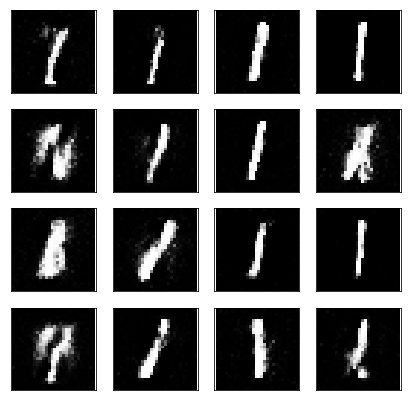

In [514]:
vie_example(sample,-1)


In [515]:
np.asarray(sample).shape

(100, 2, 16, 784)

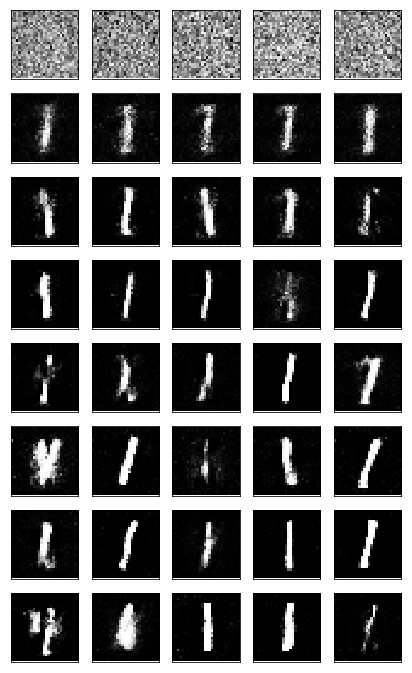

In [516]:
rows, cols = 8, 5
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sampl_sub, ax_row in zip(sample[::int(len(sample)/rows)], axes):
    for img, ax in zip(sampl_sub[::int(len(sampl)/cols)][0], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

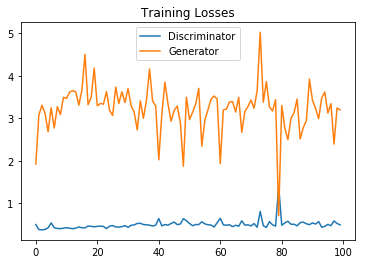

In [517]:
fig, ax = plt.subplots()
loss = np.array(loss)
plt.plot(loss.T[0], label='Discriminator')
plt.plot(loss.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [518]:
def vie_example_test(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4,ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[0]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')



INFO:tensorflow:Restoring parameters from /Applications/GAN/SGD/5_1/generator5_1


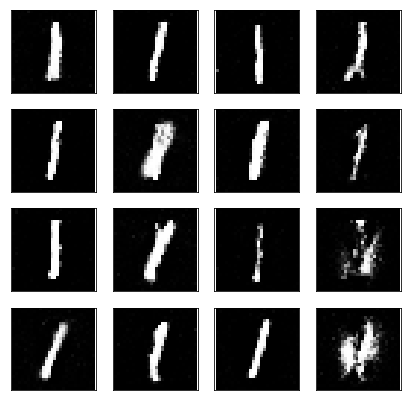

In [519]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint("/Applications/GAN/SGD/5_1"))
    sample_z = np.random.uniform(-1, 1, size=(16, 100))
    gen_samples_test = sess.run(
                       generator(z, 784,n_units,True, alpha),
                       feed_dict={z: sample_z})
vie_example_test(gen_samples_test)


In [466]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c201bef60>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c29099128>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c29099048>)

In [468]:
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [496]:
train_labels

array([1, 5, 9, ..., 3, 9, 5], dtype=int32)

In [500]:
batchsss=mnist.train.next_batch(55000)

In [501]:
batchsss[1]

array([9, 3, 6, ..., 7, 3, 5], dtype=uint8)